In [9]:
%matplotlib widget

import os
import sys
from pathlib import Path
import numpy as np
from netpyne import sim
from neuron import h
from matplotlib import pyplot as plt
import tmsneurosim

# plt.switch_backend('TkAgg')

Directories

In [10]:
study = "WeiseEtAl2023"
cur_path = os.getcwd()
rootFolder = str(Path(os.path.abspath('')))
print(cur_path)
cellFolder = f"{rootFolder}/tmsneurosim/nrn/cells/cells_hoc"
folder = sorted(os.listdir(cellFolder))
#print(folder)
# for cell in folder:
#     print(f"\"{cell}\": cells.{cell}")
celltypes = [
    "L1_NGC-DA",
    "L23_PC",
    "L23_SBC",
    "L4_LBC_cAC",
    "L4_LBC_cNAC",
    "L4_MC",
    "L4_SS",
    "L5_LBC",
    "L5_TTPC2",
    "L6_TPC",
]
cell_library = {}
for i, l in enumerate(celltypes):
    cell_library[l] = folder[i * 5 : (i + 1) * 5]

/Users/jacobtajchman/Documents/GitHub/TMS_Stimulation


nrnivmodl

In [11]:
os.chdir(f"{rootFolder}/data/{study}/mechanisms")
os.system("nrnivmodl")
os.chdir(cur_path)
os.system(f"xcopy /s/y {rootFolder}/data/{study}/mechanisms\\nrnmech.dll")

/opt/anaconda3/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/usr/bin/xcrun
/Users/jacobtajchman/Documents/GitHub/TMS_Stimulation/data/WeiseEtAl2023/mechanisms
Mod files: "./Ca.mod" "./CaDynamics_E2.mod" "./Ca_HVA.mod" "./Ca_LVAst.mod" "./Ih.mod" "./Im.mod" "./K_Pst.mod" "./K_Tst.mod" "./NaTa_t.mod" "./NaTs2_t.mod" "./Nap_Et2.mod" "./ProbAMPANMDA_EMS.mod" "./ProbGABAAB_EMS.mod" "./SK_E2.mod" "./SKv3_1.mod" "./xtra.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created x86_64/special


sh: xcopy: command not found


32512

Set up sim

In [12]:
# netParams.rotateCellsRandomly = [0, 6.2832]
# sim.createSimulateAnalyze(netParams, cfg)

# sys.path.append(rootFolder) # Reach out of "test" directory to access the rest of the code
from cfg import cfg
from netParams import netParams
from network_cell_choice import allpops

sim.initialize(
    simConfig=cfg, netParams=netParams
)  # create network object and set cfg and net params
sim.net.createPops()  # instantiate network populations
sim.net.createCells()  # instantiate network cells based on defined populations
sim.net.defineCellShapes()  # in case some cells had stylized morphologies without 3d pts
sim.net.connectCells()  # create connections between cells based on params
sim.net.addStims()  # add network stimulation
sim.setupRecording()  # setup variables to record for each cell (spikes, V traces, etc)
# cellsPost = sim.getCellsList(includePost)

# fig, _ = sim.analysis.plotShape(
#     includePre=allpops,
#     includePost=allpops,
#     includeAxon=True,
#     showSyns=False,
#     showElectrodes=False,
#     cvar="voltage",
#     dist=0.6,
#     elev=95,
#     azim=-90,
#     axisLabels=True,
#     synStyle="o",
#     clim=[-100, -50],
#     showFig=False,
#     synSize=2,
# )
# plt.show(); exit()


Start time:  2024-10-31 13:17:20.449532




Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 1 
  Done; cell creation time = 0.30 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 7 traces of 7 types on node 0


{spkt: Vector[35507], spkid: Vector[35508], stims: {cell_0: {bkg: Vector[35509]}}, V_soma: {cell_0: Vector[35517]}, V_axon_0: {cell_0: Vector[35518]}, V_axon_1: {cell_0: Vector[35519]}, V_apic_5: {cell_0: Vector[35520]}, V_apic_95: {cell_0: Vector[35521]}, V_dend_5: {cell_0: Vector[35522]}, V_dend_65: {cell_0: Vector[35523]}, t: Vector[35524], LFP: array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]]), _repr_mimebundle_: {}}

Add TMS

In [13]:
# Add extracellular stim
from extracellular_stim_tools import apply_extracellular_stim

apply_extracellular_stim(
    # List of cells to apply stim to
    cells_list=sim.net.cells, 
    # Coupling params
    decay_rate_percent_per_mm=10,
    E_field_dir={
            'Coord_type': 'Spherical',
            'Polar': 60,
            'Azimuthal': 90,
        },
    decay_dir={
            'Coord_type': 'Spherical',
            'Polar': 180,
            'Azimuthal': 0,
        },
    somatodendritic_axis=[0, 1, 0],
    # Waveform params
    stim_type='sTMS',
    simulation_duration_ms=cfg.duration,
    stim_start_ms=50.,
    efield_amplitude_V_per_m=1000.,
    tms_pulse_width_ms=1.,
    tms_pulse_shape="Ideal_Sine",
    
)

# Set up v_ext recording
vext_soma = []
vext_axon = []
for cell in sim.net.cells:
   ve_soma = h.Vector().record(cell.secs['soma_0']['hObj'](0)._ref_vext[0])
   ve_axon = h.Vector().record(cell.secs['Myelin_1']['hObj'](0.5)._ref_vext[0])
   vext_soma.append(ve_soma)
   vext_axon.append(ve_axon)
time = h.Vector().record(h._ref_t)


Applying extracellular stim (sTMS) to network...


Run sim

0.0s

Running simulation using NEURON for 100.0 ms...
0.1s
  Done; run time = 53.23 s; real-time ratio: 0.00.

Gathering data...
  Done; gather time = 0.03 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 1 (10.00 Hz)
  Simulated time: 0.1 s; 1 workers
  Run time: 53.23 s
   L5_P : 10.000 Hz
Plotting recorded cell traces ... cell


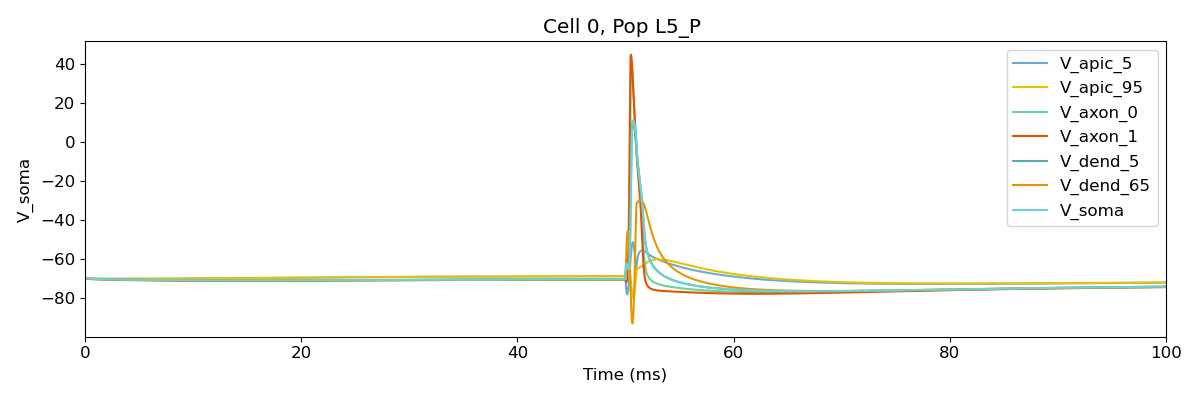

  Done; plotting time = 0.18 s

Total time = 55.00 s


In [14]:
sim.runSim()  # run parallel Neuron simulation
sim.gatherData()  # gather spiking data and cell info from each node
sim.saveData()  # save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()  # plot spike raster etc
# sim.analysis.plotShape()

Plotting

[0.0, 0.025, 0.05, 0.07500000000000001, 0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2, 0.225, 0.25, 0.275, 0.30000000000000004, 0.325, 0.35000000000000003, 0.375, 0.4, 0.42500000000000004, 0.45, 0.47500000000000003, 0.5, 0.525, 0.55, 0.5750000000000001, 0.6000000000000001, 0.625, 0.65, 0.675, 0.7000000000000001, 0.7250000000000001, 0.75, 0.775, 0.8, 0.8250000000000001, 0.8500000000000001, 0.875, 0.9, 0.925, 0.9500000000000001, 0.9750000000000001, 1.0, 1.0250000000000001, 1.05, 1.075, 1.1, 1.125, 1.1500000000000001, 1.175, 1.2000000000000002, 1.225, 1.25, 1.2750000000000001, 1.3, 1.3250000000000002, 1.35, 1.375, 1.4000000000000001, 1.425, 1.4500000000000002, 1.475, 1.5, 1.5250000000000001, 1.55, 1.5750000000000002, 1.6, 1.625, 1.6500000000000001, 1.675, 1.7000000000000002, 1.725, 1.75, 1.7750000000000001, 1.8, 1.8250000000000002, 1.85, 1.875, 1.9000000000000001, 1.925, 1.9500000000000002, 1.975, 2.0, 2.025, 2.0500000000000003, 2.075, 2.1, 2.125, 2.15, 2.1750000000000003, 2.2

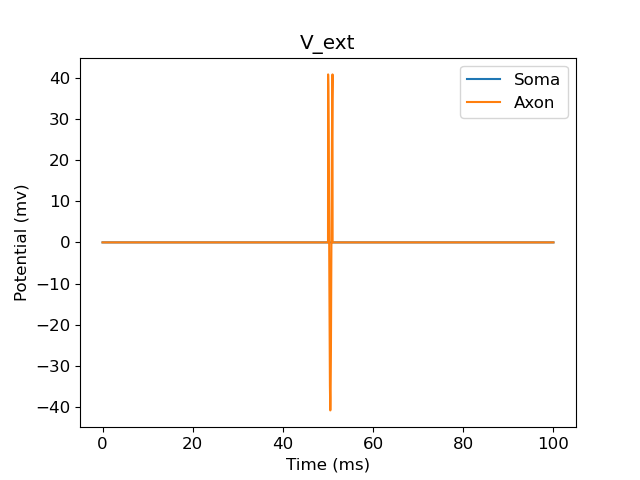

In [15]:
# sim.analysis.plotLFP(**{'plots': ['timeSeries'], 
#         'electrodes': [0], #'avg', 
#         'timeRange': [350, cfg.duration], 
#         'figSize': (12,4), 'saveFig': False, 'showFig': False})

# sim.analysis.plotShape(includePre=['E'], includePost=['E'], includeAxon=False, showSyns=False, showElectrodes=[0],
#     cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
#     axisLabels=True, synStyle='o', 
#     clim= [-80, -60], showFig=False, synSize=2)
# sim.analysis.plotShape(includePre=allpops, includePost=allpops, includeAxon=True, showSyns=False, showElectrodes=False,
#     cvar= 'voltage', dist=0.6, elev=95, azim=-90, 
#     axisLabels=True, synStyle='o', 
#     clim= [-100, -50], showFig=False, synSize=2)

npoints = int(round(cfg.duration / cfg.dt)) + 1
time = np.linspace(0, cfg.duration, npoints)
print(list(time))
print(list(vext_soma[0]))

plt.figure()
plt.plot(list(time), list(vext_soma[0]), list(time), list(vext_axon[0]))
plt.title('V_ext')
plt.xlabel('Time (ms)')
plt.ylabel('Potential (mv)')
plt.legend(['Soma', 'Axon'])

# sim.analysis.plotTraces(
#     overlay=True, oneFigPer="trace", figSize=(12, 3), fontSize=15, saveFig=False
# )

#plt.show()